<a href="https://colab.research.google.com/github/zhouire/rat_ctrnn/blob/main/navigation_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gooogle Colab Initialization Code

In [ ]:
! git clone https://github.com/zhouire/rat_ctrnn.git

Cloning into 'rat_ctrnn'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 51 (delta 17), reused 38 (delta 6), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [ ]:
cd rat_ctrnn

/content/rat_ctrnn


In [ ]:
ls

LSTM_10000iter_mask2_noreg/  rat_ctrnn_data.p              rat_model/
LSTM_1000iter_mask1/         rat_LSTM_10000iter/
movement.py                  rat_LSTM_5000iter_annealreg/


In [ ]:
# Use GPU if available; check GPU status
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec 15 19:52:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# NOTE: gast 0.2.2 seems to work better with this code, since we are using TF 1.x
! pip install gast==0.2.2

  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=f35b68728efc47cdef8fe8ff4271aa663b7f13077439a64e66a26fb50c6a5828
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


Set parameters for model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
%tensorflow_version 1.x
import tensorflow as tf
from scipy.linalg import toeplitz
import sys

%matplotlib inline

In [ ]:
learning_rate = 2e-4
#hidden_units = 96
hidden_units = 128
train_steps = 10000
ep_length = 500
sim_steps = 1000000
batch_size = 256
noise_stddev = 0.05
x_size = 2
# NOTE: set to True if not using zero regularization
anneal_regularization = False
masking = True

# Changing regularization through training to balance loss function
weights_regularization_annealed = np.linspace(100.0, 16.0, train_steps)
act_regularization_annealed = np.linspace(0.1, 0.16, train_steps)

# template for mask
# NOTE: changing this won't change the masking for the model; must change the mask params inside _Linear and MyBasicLSTMCell
mask_row = [1]*26 + [0]*(hidden_units-51) + [1]*25
mask = np.concatenate((toeplitz(mask_row, mask_row), np.ones((2, hidden_units))), axis=0)
mask = np.concatenate((mask, mask, mask, mask), axis=1)
mask = np.asarray(mask, np.float32)

model_path = 'nav_model'
data_path = 'rat_ctrnn_data.p'

Load Movement Data

In [ ]:
save_data = pickle.load(open(data_path, "rb"))
input_x = save_data["x"]
input_y = save_data["y"]
x = input_y[:, 0]
z = input_y[:, 1]

In [ ]:
print(np.shape(input_x))

(1000000, 2)


Set up model

In [ ]:
class _Linear(object):
    """Linear map: sum_i(args[i] * W[i]), where W[i] is a variable.
    """
    def __init__(self,
                args,
                output_size,
                build_bias,
                bias_initializer=None,
                kernel_initializer=None):
        self._build_bias = build_bias

        if args is None or (tf.contrib.framework.nest.is_sequence(args) and not args):
          raise ValueError("`args` must be specified")
        if not tf.contrib.framework.nest.is_sequence(args):
          args = [args]
          self._is_sequence = False
        else:
          self._is_sequence = True

        # Calculate the total size of arguments on dimension 1.
        total_arg_size = 0
        shapes = [a.get_shape() for a in args]
        for shape in shapes:
          if shape.ndims != 2:
            raise tf.ValueError("linear is expecting 2D arguments: %s" % shapes)
          if shape[1].value is None:
            raise tf.ValueError("linear expects shape[1] to be provided for shape %s, "
                            "but saw %s" % (shape, shape[1]))
          else:
            total_arg_size += shape[1].value

        dtype = [a.dtype for a in args][0]

        scope = tf.get_variable_scope()
        with tf.variable_scope(scope) as outer_scope:
          self._weights = tf.get_variable(
              "kernel", [total_arg_size, output_size],
              dtype=dtype,
              initializer=kernel_initializer)
          if build_bias:
            with tf.variable_scope(outer_scope) as inner_scope:
              inner_scope.set_partitioner(None)
              if bias_initializer is None:
                bias_initializer = tf.constant_initializer(0.0, dtype=dtype)
              self._biases = tf.get_variable(
                  "bias", [output_size],
                  dtype=dtype,
                  initializer=bias_initializer)
        
        # NOTE: masking; change mask_row to change the mask
        if masking:
          mask_row = [1]*26 + [0]*(output_size//4-51) + [1]*25
          self.mask = np.asarray(np.tile(np.concatenate((toeplitz(mask_row, mask_row), np.ones((2, output_size//4))), axis=0), 4), np.float32)
          self._weights = self._weights.assign(tf.multiply(self._weights, self.mask))

    def __call__(self, args):
        if not self._is_sequence:
          args = [args]

        if len(args) == 1:
          res = tf.matmul(args[0], self._weights)
        else:
          res = tf.matmul(tf.concat(args, 1), tf.multiply(self._weights, self.mask))
        if self._build_bias:
          res = tf.nn.bias_add(res, self._biases)
        return res


class MyBasicLSTMCell(tf.contrib.rnn.RNNCell):
    def __init__(self, num_units, forget_bias=1.0,
                activation=None, reuse=None):
        super(MyBasicLSTMCell, self).__init__(_reuse=reuse)
        self._num_units = num_units
        self._forget_bias = forget_bias
        self._activation = activation or tf.nn.tanh
        self._linear = None

        ## NOTE: change this to change masking
        if masking:
          mask_row = [1]*26 + [0]*(num_units-51) + [1]*25
          self.mask = np.asarray(np.tile(np.concatenate((toeplitz(mask_row, mask_row), np.ones((2, num_units))), axis=0), 4), np.float32)
          self.mask = tf.constant(self.mask)

    @property
    def state_size(self):
        return (tf.contrib.rnn.LSTMStateTuple(self._num_units, self._num_units))

    @property
    def output_size(self):
        return self._num_units

    def call(self, inputs, state):
        sigmoid = tf.sigmoid
        c, h = state

        if self._linear is None:
          self._linear = _Linear([inputs, h], 4 * self._num_units, True)
        # i = input_gate, j = new_input, f = forget_gate, o = output_gate
        i, j, f, o = tf.split(
            value=self._linear([inputs, h]), num_or_size_splits=4, axis=1)
        
        # NOTE: masking; this line might do nothing
        if masking:
          self._linear._weights = tf.multiply(self._linear._weights, self.mask)

        new_c = (
            c * sigmoid(f + self._forget_bias) + sigmoid(i) * self._activation(j))
        new_h = self._activation(new_c) * sigmoid(o)
        new_h = tf.add(new_h,
                      tf.random_normal(shape=tf.shape(new_h), mean=0.0, stddev=noise_stddev, dtype=tf.float32))

        new_state = tf.contrib.rnn.LSTMStateTuple(new_c, new_h)
        return new_h, new_state

In [ ]:
class RatRNN(object):
    def __init__(self, x_size, y_size, h_size, lr):
        self.x = tf.placeholder(shape=[None, x_size], dtype=tf.float32)
        self.train_length = tf.placeholder(shape=[1], dtype=tf.int32)
        self.batch_size = tf.placeholder(shape=[1], dtype=tf.int32)

        self.rnn_in = tf.reshape(self.x, shape=[self.batch_size[0], self.train_length[0], x_size])

        cell = MyBasicLSTMCell(h_size)
        self.state_in = cell.zero_state(self.batch_size[0], tf.float32)

        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(inputs=self.rnn_in, cell=cell, dtype=tf.float32,
                                                     initial_state=self.state_in)
        
        self.output = tf.reshape(self.rnn, shape=[-1, h_size])  
        
        self.y_pred = tf.layers.dense(self.output, y_size, activation=None)

        self.y = tf.placeholder(shape=[None, y_size], dtype=tf.float32)
        
        lossL2A = tf.nn.l2_loss(self.output)
        
        lossL2W = tf.add_n([ tf.nn.l2_loss(v) for v in tf.trainable_variables()
                           if 'bias' not in v.name ])
        
        # useful for annealed regularization
        self.weights_regularization = tf.placeholder(tf.float32, shape=[])
        self.act_regularization = tf.placeholder(tf.float32, shape=[])

        self.weights_loss = lossL2W * self.weights_regularization
        self.act_loss = lossL2A * self.act_regularization
        self.regress_loss = tf.reduce_sum(tf.squared_difference(self.y, self.y_pred))
        self.loss = self.regress_loss + self.weights_loss + self.act_loss

        self.loss = tf.Print(self.loss, [lossL2A, lossL2W, self.regress_loss])

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update = optimizer.minimize(self.loss)

In [ ]:
tf.reset_default_graph()
rat_rnn = RatRNN(x_size, 2, hidden_units, learning_rate)
sess = tf.InteractiveSession()
saver = tf.train.Saver()

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [ ]:
print(tf.trainable_variables())
print(tf.global_variables())

[<tf.Variable 'rnn/my_basic_lstm_cell/kernel:0' shape=(130, 512) dtype=float32_ref>, <tf.Variable 'rnn/my_basic_lstm_cell/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'dense/kernel:0' shape=(128, 2) dtype=float32_ref>, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32_ref>]
[<tf.Variable 'rnn/my_basic_lstm_cell/kernel:0' shape=(130, 512) dtype=float32_ref>, <tf.Variable 'rnn/my_basic_lstm_cell/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'dense/kernel:0' shape=(128, 2) dtype=float32_ref>, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32_ref>, <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>, <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>, <tf.Variable 'rnn/my_basic_lstm_cell/kernel/Adam:0' shape=(130, 512) dtype=float32_ref>, <tf.Variable 'rnn/my_basic_lstm_cell/kernel/Adam_1:0' shape=(130, 512) dtype=float32_ref>, <tf.Variable 'rnn/my_basic_lstm_cell/bias/Adam:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'rnn/my_basic_lstm_cell/bias/Adam_

Train network

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

500 2000.0


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

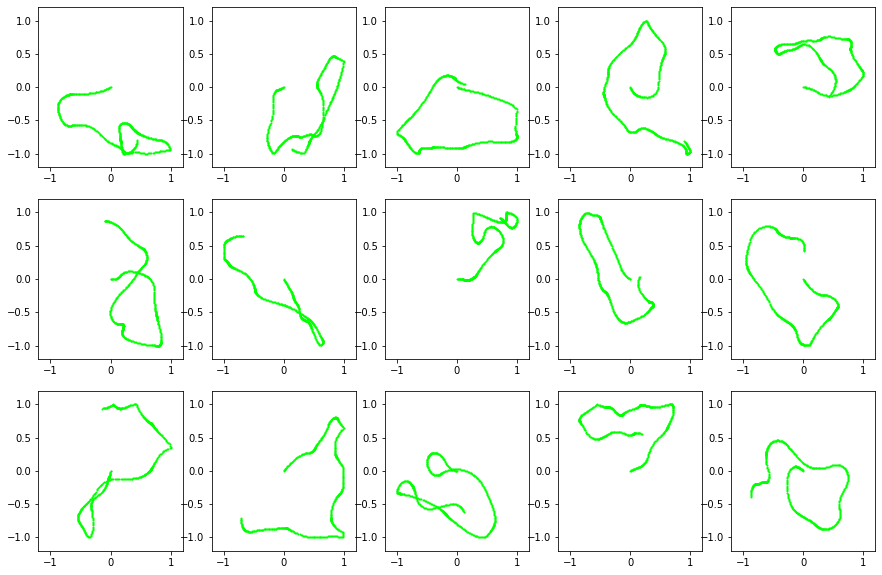

In [ ]:
losses = []
init = tf.global_variables_initializer()
sess.run(init)
print(ep_length, sim_steps/ep_length)

# center training data (if not already centered)
input_Y = np.copy(input_y)
for i in range(sim_steps//ep_length):
    pointer = i
    input_Y[pointer*ep_length:(pointer+1)*ep_length] -= input_Y[pointer*ep_length]

# visualize example paths passed into model
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_y = input_Y[pointer*ep_length:(pointer+1)*ep_length]
    
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
plt.show()

Loss: 84096.3125 -- 1
Loss: 84173.40625 -- 2
Loss: 82699.734375 -- 3
Loss: 84938.9453125 -- 4
Loss: 85937.0625 -- 5
Loss: 83770.4921875 -- 6
Loss: 84529.4375 -- 7
Loss: 82499.6796875 -- 8
Loss: 83226.0703125 -- 9
Loss: 85166.5 -- 10
Loss: 83286.09375 -- 11
Loss: 81797.0 -- 12
Loss: 82078.6875 -- 13
Loss: 80511.1484375 -- 14
Loss: 79044.7265625 -- 15
Loss: 80443.265625 -- 16
Loss: 74357.078125 -- 17
Loss: 68079.40625 -- 18
Loss: 63244.96875 -- 19
Loss: 58633.9765625 -- 20
Loss: 58632.0 -- 21
Loss: 59343.90234375 -- 22
Loss: 57441.390625 -- 23
Loss: 55227.203125 -- 24
Loss: 57932.4765625 -- 25
Loss: 56637.9921875 -- 26
Loss: 56018.0703125 -- 27
Loss: 54478.4140625 -- 28
Loss: 51064.77734375 -- 29
Loss: 51981.8984375 -- 30
Loss: 47094.5078125 -- 31
Loss: 50211.5390625 -- 32
Loss: 45285.40234375 -- 33
Loss: 41281.34375 -- 34
Loss: 43089.3984375 -- 35
Loss: 39121.62109375 -- 36
Loss: 35664.44921875 -- 37
Loss: 36110.125 -- 38
Loss: 32676.818359375 -- 39
Loss: 32709.0546875 -- 40
Loss: 31048

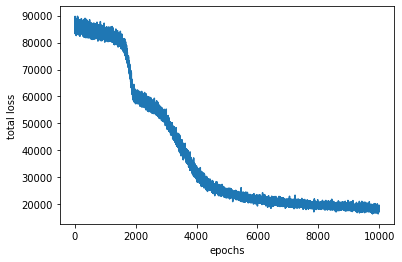

In [ ]:
for i in range(train_steps):
    pointer = np.random.randint(0, sim_steps/ep_length - batch_size)
    batch_x = input_x[pointer*ep_length:(pointer+batch_size)*ep_length]
    batch_y = input_Y[pointer*ep_length:(pointer+batch_size)*ep_length]
    
    if anneal_regularization:
        feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,x_size]), rat_rnn.y: np.reshape(batch_y, [-1, 2]), 
                    rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [batch_size],
                    rat_rnn.weights_regularization: weights_regularization_annealed[i], 
                    rat_rnn.act_regularization: act_regularization_annealed[i]}
    # this is used for zero regularization
    else:
        feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,x_size]), rat_rnn.y: np.reshape(batch_y, [-1, 2]), 
                    rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [batch_size],
                    rat_rnn.weights_regularization: 0, 
                    rat_rnn.act_regularization: 0}

    loss, _ = sess.run([rat_rnn.loss, rat_rnn.update], feed_dict=feed_dict)
    if i % 100 == 0 and i != 0:
        print("Loss: {} -- {}".format(loss, i//100))
    losses.append(loss)

plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('total loss')
plt.show()

In [ ]:
#model_path = "LSTM_10000iter_mask1D_51conn_annealreg_100-16,1-1.6_lr4e-4"

if not os.path.exists(model_path):
    os.makedirs(model_path)

saver.save(sess, model_path + '/model.cptk')

'nav_model/model.cptk'

Load network weights

In [ ]:
ckpt = tf.train.get_checkpoint_state(model_path)
if ckpt == None:
  print('The model {0} could not be found. Make sure you specified the right '
    '--run-path'.format(model_path))
saver.restore(sess, ckpt.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from nav_model/model.cptk


Plot Model Prediction Results

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

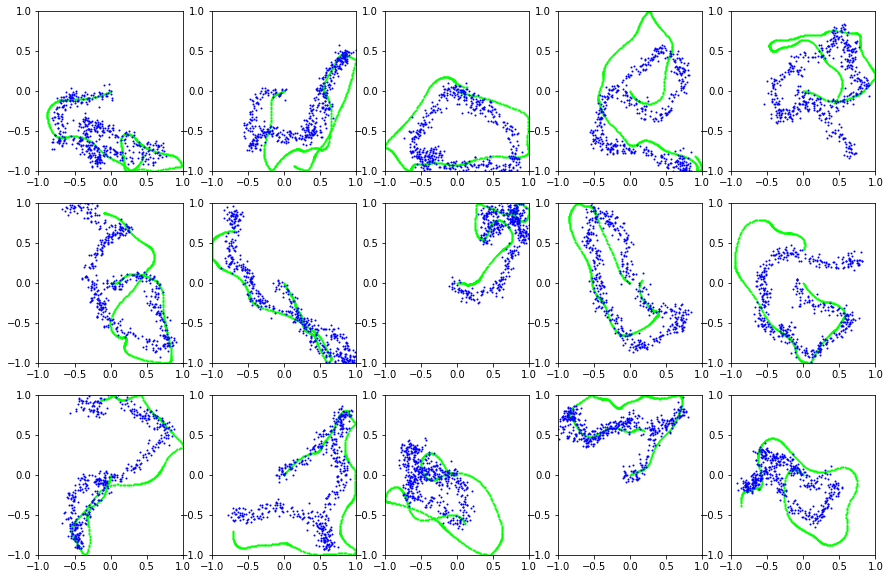

In [ ]:
plt.figure(figsize=(15,10))
for i in range(15):
    pointer = i
    batch_x = input_x[pointer*ep_length:(pointer+1)*ep_length]
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,x_size]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [1]}
    yp = sess.run(rat_rnn.y_pred, feed_dict=feed_dict) + batch_y[0]
    
    # Real - Green | Predicted - Blue
    plt.subplot(3, 5, 1 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.scatter(yp[:, 0], yp[:, 1], s=1, c=[0,0,1,1])
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
plt.show()

Display neuron activation patterns

In [ ]:
resolution = 32
#maze_extents = 4.5
maze_extents = 1
rate = np.zeros([hidden_units, resolution, resolution])
count = np.zeros([resolution, resolution])
for i in range(min(5000,len(input_x)//ep_length)):
    pointer = i
    batch_x = input_x[pointer*ep_length:(pointer+1)*ep_length]
    batch_y = input_y[pointer*ep_length:(pointer+1)*ep_length]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,x_size]), 
                 rat_rnn.train_length: [ep_length], rat_rnn.batch_size: [1]}
    act = sess.run(rat_rnn.output, feed_dict=feed_dict)
    
    for j in range(ep_length):
        x = (batch_y[j][0] + maze_extents)/(maze_extents*2) * resolution
        y = (batch_y[j][1] + maze_extents)/(maze_extents*2) * resolution
        count[int(x), int(y)] += 1
        rate[:, int(x), int(y)] += np.abs(act[j, :])
                      
for x in range(resolution):
    for y in range(resolution):
        if count[x, y] > 0:
            rate[:, x, y] /= count[x, y]

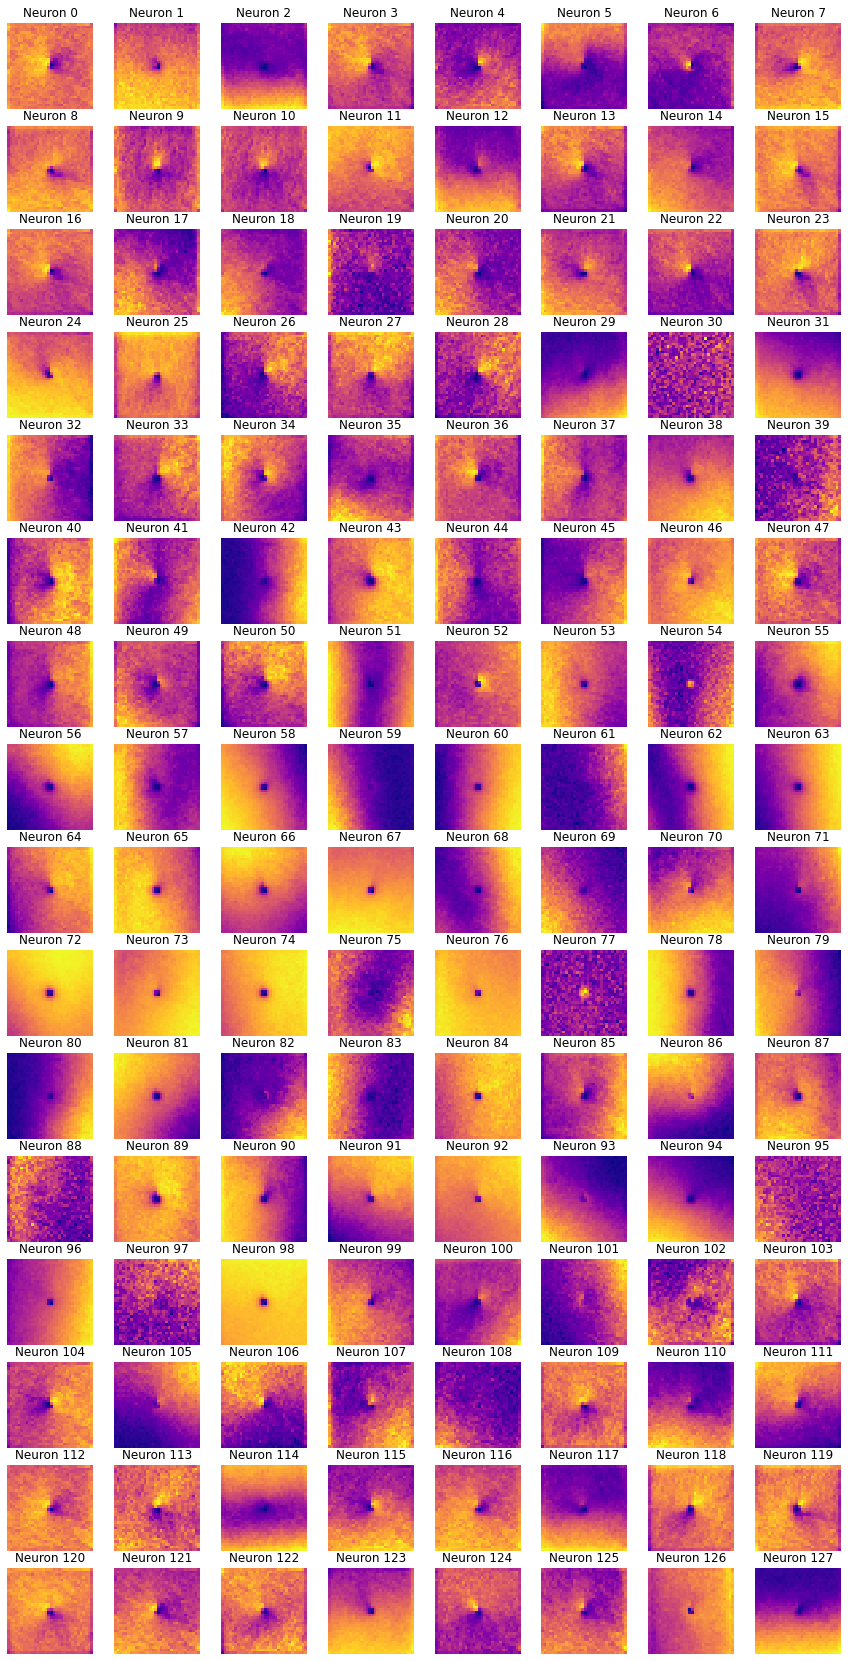

In [ ]:
plt.figure(figsize=(15,30))
for h in range(hidden_units):
    plt.subplot(hidden_units//8, 8, 1 + h)
    plt.title('Neuron ' + str(h))
    plt.imshow(rate[h,:,:] / np.max(rate[h,:,:]), interpolation="nearest", cmap="plasma")
    plt.axis('off')
    
plt.show()

In [ ]:
# debugging; make sure masking is working by checking the weight matrix
print(tf.trainable_variables())
print(sess.run('rnn/my_basic_lstm_cell/kernel:0')[0])

[<tf.Variable 'rnn/my_basic_lstm_cell/kernel:0' shape=(130, 512) dtype=float32_ref>, <tf.Variable 'rnn/my_basic_lstm_cell/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'dense/kernel:0' shape=(128, 2) dtype=float32_ref>, <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32_ref>]
[ 0.02749541  0.05728737  0.08512452 -0.06807406 -0.07696085 -0.08113125
  0.0115516   0.05121426  0.08379559 -0.03498102 -0.00184093 -0.03349845
 -0.04074232 -0.00039969  0.07842796 -0.0289901  -0.08467107  0.05576059
  0.0003175   0.03421257 -0.02708153  0.01041041  0.04124413  0.07405661
  0.0931958   0.0386548  -0.         -0.         -0.          0.
  0.          0.          0.         -0.         -0.          0.
 -0.         -0.          0.          0.          0.          0.
  0.          0.          0.         -0.          0.         -0.
  0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.   

In [ ]:
# shut down the tensorflow session
sess.close()